In [420]:
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import string
import numpy as np

##### Test

In [421]:
num_nodes = 4
num_trailers = 3
num_trucks = 2
graph = nx.complete_graph(num_nodes, nx.MultiDiGraph())

In [422]:
# set coordinates for each node
node_position = dict(enumerate(np.random.rand(num_nodes, 2)))
nx.set_node_attributes(graph, node_position, name="coordinates")

# set num_chargers for each node
num_chargers = np.random.randint(low=1, high=10, size=(num_nodes, 1))
nx.set_node_attributes(graph, dict(enumerate(num_chargers)), name="num_chargers")

# set available_chargers for each node
nx.set_node_attributes(graph, dict(enumerate(num_chargers)), name="available_chargers")

# set trailers
nx.set_node_attributes(graph, None, name="trailers")

trailer_index = string.ascii_uppercase
trailer_origin_nodes = np.random.choice(graph.nodes, num_trailers)

for i, node_id in enumerate(trailer_origin_nodes):
    # Assign a random destination to each trailer
    destination = np.random.choice([n for n in graph.nodes if n != node_id])
    start_time = np.random.randint(low=8.00, high=18.00)
    time_frame = np.round(np.random.uniform(low=0.5, high=2)*2) / 2

    if graph.nodes[node_id]["trailers"] is None: graph.nodes[node_id]["trailers"] = {}
    graph.nodes[node_id]["trailers"][f"Trailer {trailer_index[i]}"] = { 
        'destination_node': destination,
        'start_time': np.round(start_time, 2),
        'end_time': start_time + time_frame
    }

# set trucks
nx.set_node_attributes(graph, None, name="trucks")
truck_nodes = np.random.choice(graph.nodes, num_trucks)

for i, node_id in enumerate(truck_nodes):
    if graph.nodes[node_id]["trucks"] is None: graph.nodes[node_id]["trucks"] = {}
    graph.nodes[node_id]["trucks"][f'Truck {i}'] = { 
        'battery_level': 1
    }

# # Edge Attributes
# nx.set_edge_attributes(graph, {'truck': None, 'trailer': None, 'timestamp': None})


In [423]:
dict(graph.nodes.data())

{0: {'coordinates': array([0.42506995, 0.92756307]),
  'num_chargers': array([8]),
  'available_chargers': array([8]),
  'trailers': None,
  'trucks': {'Truck 1': {'battery_level': 1}}},
 1: {'coordinates': array([0.88334278, 0.05505502]),
  'num_chargers': array([5]),
  'available_chargers': array([5]),
  'trailers': {'Trailer A': {'destination_node': 2,
    'start_time': 11,
    'end_time': 13.0}},
  'trucks': None},
 2: {'coordinates': array([0.09063074, 0.28298272]),
  'num_chargers': array([6]),
  'available_chargers': array([6]),
  'trailers': {'Trailer B': {'destination_node': 0,
    'start_time': 14,
    'end_time': 16.0}},
  'trucks': {'Truck 0': {'battery_level': 1}}},
 3: {'coordinates': array([0.94425461, 0.85303225]),
  'num_chargers': array([4]),
  'available_chargers': array([4]),
  'trailers': {'Trailer C': {'destination_node': 1,
    'start_time': 16,
    'end_time': 17.0}},
  'trucks': None}}

In [424]:
dict(graph.edges)

{(0, 1, 0): {},
 (0, 2, 0): {},
 (0, 3, 0): {},
 (1, 0, 0): {},
 (1, 2, 0): {},
 (1, 3, 0): {},
 (2, 0, 0): {},
 (2, 1, 0): {},
 (2, 3, 0): {},
 (3, 0, 0): {},
 (3, 1, 0): {},
 (3, 2, 0): {}}

In [425]:
def get_trailer_labels(data):
    node_trailers = {}
    for node_id, trailers_data in data.items():
        if trailers_data is not None:
            # origin
            if node_id not in node_trailers: node_trailers[node_id] = ""
            node_trailers[node_id] += str(list(trailers_data.keys())) + "\n"

            for trailer_id, trailer_data in trailers_data.items():
                destination_node = trailer_data['destination_node']

                # destination
                if destination_node not in node_trailers: node_trailers[destination_node] = ""
                node_trailers[destination_node] += f"{trailer_id} : {trailer_data['start_time']:.2f} - {trailer_data['end_time']:.2f} \n"
                
    return node_trailers

In [426]:
def bezier_control_point(pos_source, pos_target, offset):
    x1, y1 = pos_source
    x2, y2 = pos_target
    x_mid = (x1 + x2) / 2
    y_mid = (y1 + y2) / 2
    x_control = x_mid - offset * (y2 - y1)
    y_control = y_mid + offset * (x2 - x1)
    return x_control, y_control

In [427]:
# # add edges that where visited
# edges = [
#     (0, 3, 'Truck 1', 'Trailer B', 1),
#     (0, 3, 'Truck 2', None, 2),
#     (3, 2, 'Truck 1', 'Trailer A', 3),
#     (3, 2, 'Truck 2', 'Trailer C', 4),
# ]
#
# graph.add_edges_from((u, v, {'truck': truck, 'trailer': trailer, 'timestamp': timestamp}) for u, v, truck, trailer, timestamp in edges)

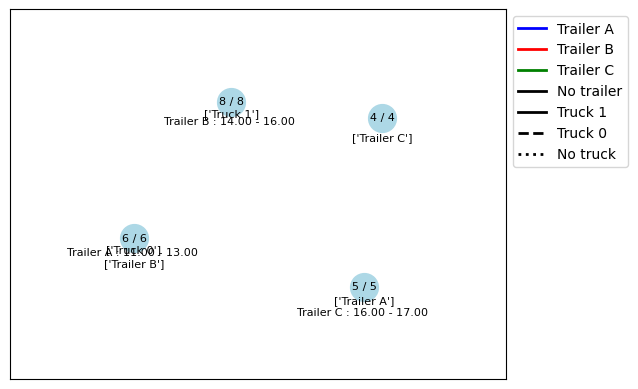

In [428]:
# image 1
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)
# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)
#
# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()


##### Solution Display

In [484]:
nx.set_node_attributes(graph, {0: {'coordinates': [0.81568734, 0.46616891],
  'num_chargers': [2],
  'available_chargers': [2],
  'trailers': {'Trailer A': {'destination_node': 3,
    'start_time': 14,
    'end_time': 15.0},
   'Trailer C': {'destination_node': 3, 'start_time': 9, 'end_time': 10.0}},
  'trucks': None},
 1: {'coordinates': [0.45070739, 0.77785083],
  'num_chargers': [9],
  'available_chargers': [9],
  'trailers': None,
  'trucks': {'Truck 0': {'battery_level': 1}}},
 2: {'coordinates': [0.06070113, 0.53816134],
  'num_chargers':  [7],
  'available_chargers': [7],
  'trailers': None,
  'trucks': {'Truck 1': {'battery_level': 1}}},
 3: {'coordinates': [0.39932656, 0.17680608],
  'num_chargers': [8],
  'available_chargers': [8],
  'trailers': {'Trailer B': {'destination_node': 2,
    'start_time': 16,
    'end_time': 17.5}},
  'trucks': None}})

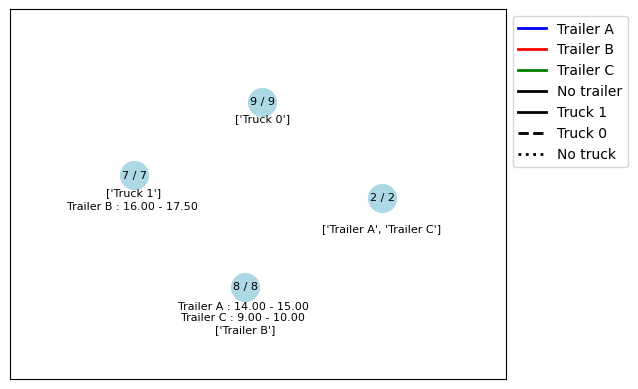

In [485]:
# image 1
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)
# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

In [486]:
# add edges that where visited
graph.remove_edges_from(dict(graph.edges))
edges = [
    (2, 0, 'Truck 1', None, 1)
]

graph.add_edges_from((u, v, {'truck': truck, 'trailer': trailer, 'timestamp': timestamp}) for u, v, truck, trailer, timestamp in edges)


[0]

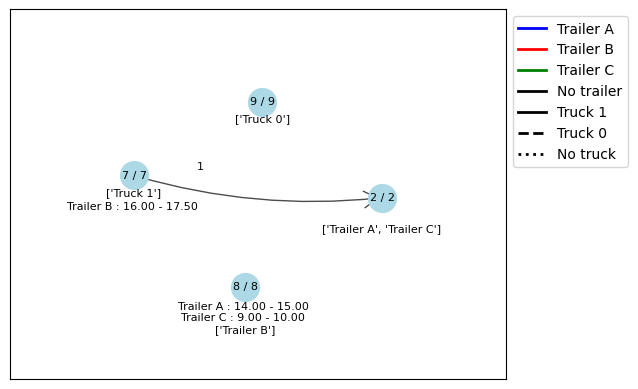

In [487]:
# image 2
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

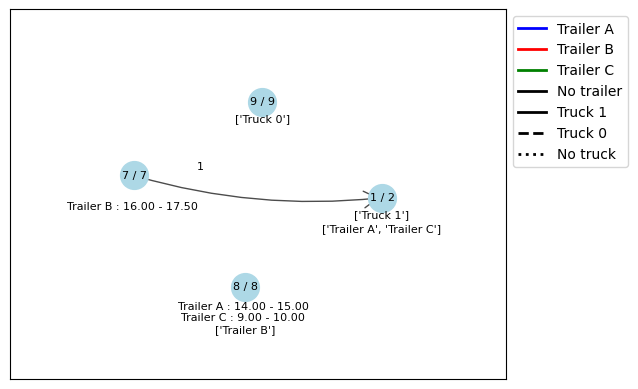

In [488]:
# update state
nx.set_node_attributes(graph, {2: {"trucks": None}, 0: {"available_chargers": [1], "trucks": {'Truck 1': {'battery_level': 0}}}})
# image 2.2
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()


In [489]:
# add edges that where visited
# graph.remove_edges_from(dict(graph.edges))
edges = [
    (1, 0, 'Truck 0', None, 2)
]

graph.add_edges_from(
    (u, v, {'truck': truck, 'trailer': trailer, 'timestamp': timestamp}) for u, v, truck, trailer, timestamp in edges)


[0]

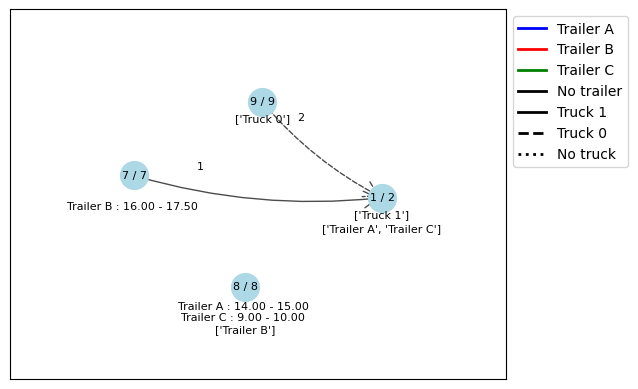

In [490]:
# image 3
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

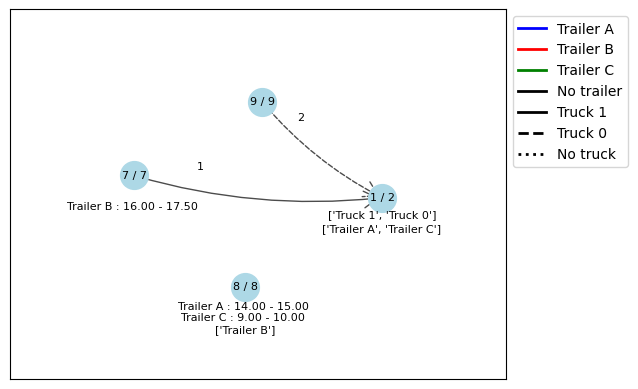

In [491]:
# update state
nx.set_node_attributes(graph, {1: {"trucks": None}, 0: {"available_chargers": [1], "trucks": {'Truck 1': {'battery_level': 0}, 'Truck 0': {'battery_level': 1}, }}})
# image 3.2
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()


In [492]:
# add edges that where visited
# graph.remove_edges_from(dict(graph.edges))
edges = [
    (0, 3, 'Truck 1', 'Trailer C', 3)
]

graph.add_edges_from(
    (u, v, {'truck': truck, 'trailer': trailer, 'timestamp': timestamp}) for u, v, truck, trailer, timestamp in edges)


[0]

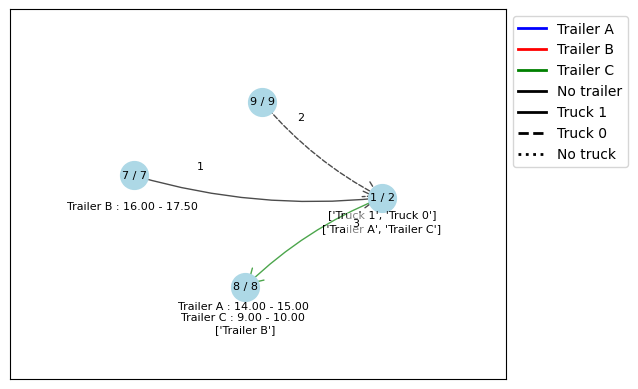

In [493]:
# image 4
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.09])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.6])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)

from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

In [494]:
style | color

{'Truck 1': 'solid',
 'Truck 0': 'dashed',
 None: 'black',
 'Trailer A': 'blue',
 'Trailer B': 'red',
 'Trailer C': 'green'}

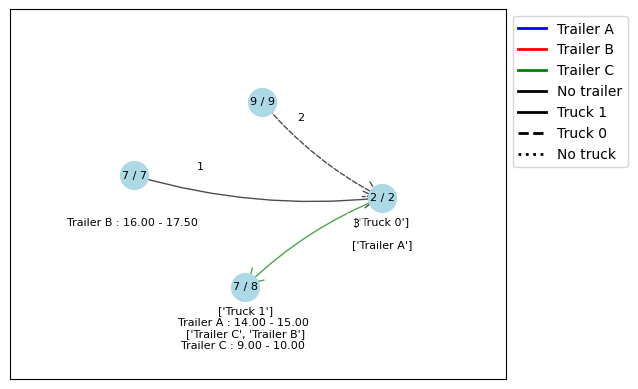

In [503]:
# update state
nx.set_node_attributes(graph, {0: {"trucks":  {'Truck 0': {'battery_level': 1}}, "available_chargers": [2], "trailers": {'Trailer A': {'destination_node': 3, 'start_time': 14, 'end_time': 15.0}}},
                               3: {"available_chargers": [7], "trucks": {'Truck 1': {'battery_level': 0}}, "trailers": { 'Trailer C': {'destination_node': 3, 'start_time': 9, 'end_time': 10.0}, 'Trailer B': {'destination_node': 2,'start_time': 16,'end_time': 17.5}}}})

# image 4.2
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.13])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.86])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()


In [478]:
# add edges that where visited
edges = [
    (0, 3, 'Truck 0', 'Trailer A', 4)
]

graph.add_edges_from(
    (u, v, {'truck': truck, 'trailer': trailer, 'timestamp': timestamp}) for u, v, truck, trailer, timestamp in edges)


[1]

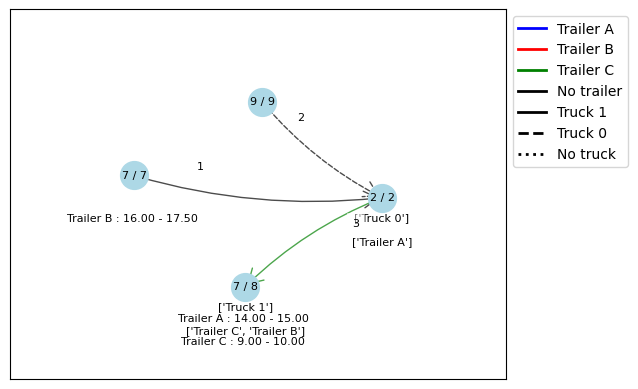

In [509]:
# image 5
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.11])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.8])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

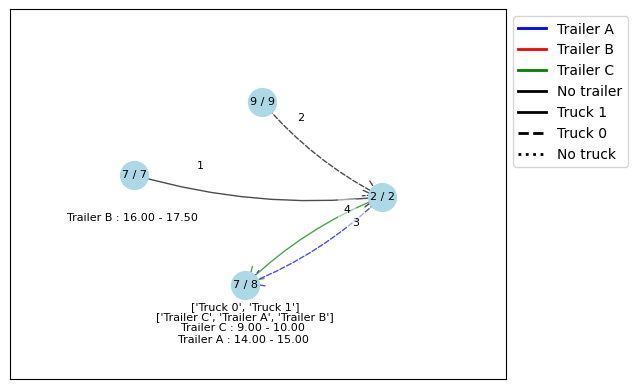

In [480]:
# update state
nx.set_node_attributes(graph, {0: {"trucks":  None, "available_chargers": [2], "trailers": None},
                       3: {"available_chargers": [7], "trucks": {'Truck 0': {'battery_level': 1}, 'Truck 1': {'battery_level': 0}}, "trailers": { 'Trailer C': {'destination_node': 3, 'start_time': 9, 'end_time': 10.0}, 'Trailer A': {'destination_node': 3, 'start_time': 14, 'end_time': 15.0}, 'Trailer B': {'destination_node': 2,'start_time': 16,'end_time': 17.5}}}})

# image 5.2
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.12])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.8])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

In [481]:
# add edges that where visited
edges = [
    (3, 2, 'Truck 1', 'Trailer B', 5)
]

graph.add_edges_from(
    (u, v, {'truck': truck, 'trailer': trailer, 'timestamp': timestamp}) for u, v, truck, trailer, timestamp in edges)


[0]

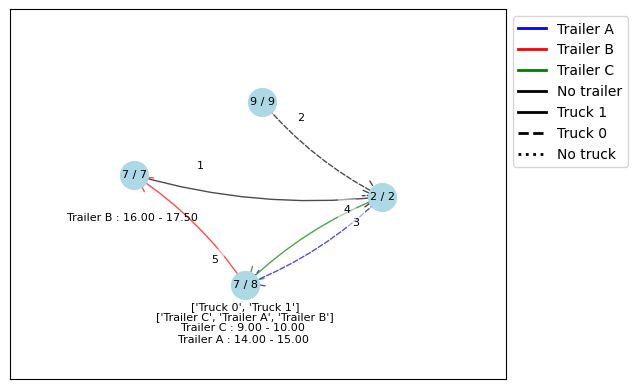

In [482]:
# image 6
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.12])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.8])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

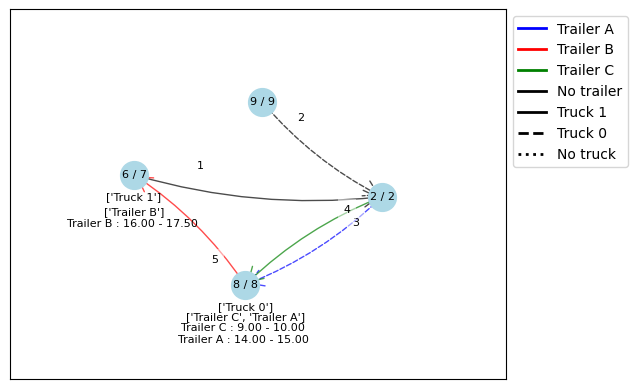

In [483]:
# update state
nx.set_node_attributes(graph, {2: {"trucks":  {'Truck 1': {'battery_level': 0}}, "available_chargers": [6], "trailers": {'Trailer B': {'destination_node': 2,'start_time': 16,'end_time': 17.5}}},
                               3: {"available_chargers": [8], "trucks": {'Truck 0': {'battery_level': 1}}, "trailers": { 'Trailer C': {'destination_node': 3, 'start_time': 9, 'end_time': 10.0}, 'Trailer A': {'destination_node': 3, 'start_time': 14, 'end_time': 15.0}}}})
# image 6.2
fig, ax = plt.subplots()
pos = nx.get_node_attributes(graph, "coordinates")

color = {'Trailer A': 'blue', 'Trailer B': 'red', 'Trailer C': 'green', None: 'black'}
style = {'Truck 1': 'solid', 'Truck 0': 'dashed', None: 'solid'}

# draw chargers
node_num_chargers = nx.get_node_attributes(graph, "num_chargers")
node_available_chargers= nx.get_node_attributes(graph, "available_chargers")

node_num_chargers = {node_id: f'{avail_charg[0]} / {num_charg[0]}' for (node_id, num_charg), avail_charg in zip(node_num_chargers.items(), node_available_chargers.values())}
nx.draw_networkx_labels(
    graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
)

# draw trucks
label_offset = np.array([0, 0.12])
truck_label_pos = {k: (v - 0.6*label_offset) for k, v in pos.items()}

node_trucks_data = nx.get_node_attributes(graph, "trucks")
node_trucks_labels = {node_id: list(trucks_data.keys()) for (node_id, trucks_data) in node_trucks_data.items() if trucks_data is not None}

nx.draw_networkx_labels(
    graph, pos=truck_label_pos, labels=node_trucks_labels, ax=ax, font_size=8
)
#
# draw trailers
label_offset = np.array([0, 0.8])
trailer_label_pos = {k: (v - 0.2*label_offset) for k, v in pos.items()}

node_trailers_data = nx.get_node_attributes(graph, "trailers")
node_trailers_labels =  get_trailer_labels(node_trailers_data)

nx.draw_networkx_labels(
    graph, pos=trailer_label_pos, labels=node_trailers_labels, ax=ax, font_size=8
)

# draw edges
for edge in graph.edges(data=True, keys=True):
    _, _, key, data = edge
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:
        truck, trailer, timestamp = data['truck'], data['trailer'], data['timestamp']

        data['color'] = color[trailer]
        data['style'] = style[truck]
        data['label'] = str(timestamp)

for u, v, key, data in graph.edges(data=True, keys=True):
    if 'truck' in data and 'trailer' in data and 'timestamp' in data:

        pos_source = pos[u]
        pos_target = pos[v]

        if key % 2 == 0:
            offset = 0.1
        else:
            offset = -0.1

        x_control, y_control = bezier_control_point(pos_source, pos_target, offset)

        arrow = FancyArrowPatch(
            pos_source, pos_target,
            connectionstyle=f"arc3, rad={offset}",
            arrowstyle="->, head_length=0.5, head_width=0.3",
            linestyle=data['style'], linewidth=1, color=data['color'], zorder=-key, alpha=0.7,
            mutation_scale=20
        )

        ax.add_patch(arrow)

        x_label = (pos_source[0] + x_control) / 2
        y_label = (pos_source[1] + y_control) / 2
        plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

# Draw nodes and labels
nx.draw_networkx_nodes(graph, pos=pos, node_size=400, node_color='lightblue', ax=ax,  margins=0.5)
from matplotlib.lines import Line2D

custom_lines=[Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2),  Line2D([0], [0], color='green', lw=2),  Line2D([0], [0], color='black', lw=2), Line2D([0], [0], color='black', lw=2, ls='-'), Line2D([0], [0], color='black', lw=2, ls='--'), Line2D([0], [0], color='black', lw=2, ls=':')]
plt.legend(custom_lines, ['Trailer A', 'Trailer B', 'Trailer C', 'No trailer', 'Truck 1', 'Truck 0', 'No truck'], bbox_to_anchor=(1.26, 1))
plt.show()

##### Network

In [382]:
class Network:
    graph: nx.Graph = nx.Graph()

    def __init__(
        self,
        num_nodes: int,
        num_trailers: int,
        num_trucks: int,
        plot_attributes: bool = False,
    ):
        """
        Creates a fully connected and directed graph with node_num nodes.
        Coordinates of each node will be sampled randomly.

        Args:
            node_num (int): Number of nodes in the graph.
        """
        self.num_nodes = num_nodes
        self.num_trucks = num_trucks
        self.num_trailers = num_trailers
        self.plot_attributes = plot_attributes

        # generate graph and set node position
        self.graph = nx.complete_graph(num_nodes, nx.MultiDiGraph())
        self.set_default_attributes()

    def set_default_attributes(self):
        """
        Sets the default colors of the nodes
        as attributes. Nodes are black except
        depots which are colored in red.

        Edges are initially marked as unvisited.
        """

        # Node Attributes

        # set coordinates for each node
        node_position = dict(enumerate(np.random.rand(self.num_nodes, 2)))
        nx.set_node_attributes(self.graph, node_position, name="coordinates")

        # set num_chargers for each node
        num_chargers = np.random.randint(low=1, high=10, size=(self.num_nodes, 1))
        nx.set_node_attributes(
            self.graph, dict(enumerate(num_chargers)), name="num_chargers"
        )

        # set available_chargers for each node
        nx.set_node_attributes(
            self.graph, dict(enumerate(num_chargers)), name="available_chargers"
        )

        # set trailers
        nx.set_node_attributes(self.graph, None, name="trailers")

        trailer_index = string.ascii_uppercase
        trailer_origin_nodes = np.random.choice(self.graph.nodes, self.num_trailers)

        for i, node_id in enumerate(trailer_origin_nodes):
            # Assign a random destination to each trailer
            destination = np.random.choice(
                [n for n in self.graph.nodes if n != node_id]
            )
            start_time = np.random.randint(low=8.00, high=18.00)
            time_frame = np.round(np.random.uniform(low=0.5, high=2) * 2) / 2

            if self.graph.nodes[node_id]["trailers"] is None:
                self.graph.nodes[node_id]["trailers"] = {}
            self.graph.nodes[node_id]["trailers"][f"Trailer {trailer_index[i]}"] = {
                "destination_node": destination,
                "start_time": np.round(start_time, 2),
                "end_time": start_time + time_frame,
            }

        # set trucks
        nx.set_node_attributes(self.graph, None, name="trucks")
        truck_nodes = np.random.choice(self.graph.nodes, self.num_trucks)

        for i, node_id in enumerate(truck_nodes):
            if self.graph.nodes[node_id]["trucks"] is None:
                self.graph.nodes[node_id]["trucks"] = {}
            self.graph.nodes[node_id]["trucks"][f"Truck {i}"] = {"battery_level": 1}

        # set general attributes
        nx.set_node_attributes(self.graph, "black", "node_color")

    def get_trailer_labels(self, data):
        node_trailers = {}
        for node_id, trailers_data in data.items():
            if trailers_data is not None:
                # origin
                if node_id not in node_trailers:
                    node_trailers[node_id] = ""
                node_trailers[node_id] += str(list(trailers_data.keys())) + "\n"

                for trailer_id, trailer_data in trailers_data.items():
                    destination_node = trailer_data["destination_node"]

                    # destination
                    if destination_node not in node_trailers:
                        node_trailers[destination_node] = ""
                    node_trailers[
                        destination_node
                    ] += f"{trailer_id} : {trailer_data['start_time']:.2f} - {trailer_data['end_time']:.2f} \n"

        return node_trailers
    
    def bezier_control_point(self, pos_source, pos_target, offset):
        x1, y1 = pos_source
        x2, y2 = pos_target
        x_mid = (x1 + x2) / 2
        y_mid = (y1 + y2) / 2
        x_control = x_mid - offset * (y2 - y1)
        y_control = y_mid + offset * (x2 - x1)

        return x_control, y_control

    def draw(self, ax, with_labels=False):
        """
        Draws the graph as a matplotlib plot.
        """

        # draw nodes according to color and position attribute
        pos = nx.get_node_attributes(self.graph, "coordinates")
        node_colors = nx.get_node_attributes(self.graph, "node_color").values()
        nx.draw_networkx_nodes(
            self.graph,
            pos=pos,
            node_color=node_colors,
            ax=ax,
            node_size=400,
            margins=0.5,
        )

        # draw attributes
        if self.plot_attributes:
            color = {
                "Trailer A": "blue",
                "Trailer B": "red",
                "Trailer C": "green",
                None: "black",
            }
            style = {"Truck 1": "solid", "Truck 0": "dashed", None: "solid"}

            # chargers
            node_num_chargers = nx.get_node_attributes(self.graph, "num_chargers")
            node_available_chargers = nx.get_node_attributes(
                self.graph, "available_chargers"
            )

            node_num_chargers = {
                node_id: f"{avail_charg[0]} / {num_charg[0]}"
                for (node_id, num_charg), avail_charg in zip(
                    node_num_chargers.items(), node_available_chargers.values()
                )
            }
            nx.draw_networkx_labels(
                self.graph, pos=pos, labels=node_num_chargers, ax=ax, font_size=8
            )
            # trucks
            label_offset = np.array([0, 0.09])
            truck_label_pos = {k: (v - 0.6 * label_offset) for k, v in pos.items()}

            node_trucks_data = nx.get_node_attributes(self.graph, "trucks")
            node_trucks_labels = {
                node_id: list(trucks_data.keys())
                for (node_id, trucks_data) in node_trucks_data.items()
                if trucks_data is not None
            }

            nx.draw_networkx_labels(
                self.graph,
                pos=truck_label_pos,
                labels=node_trucks_labels,
                ax=ax,
                font_size=8,
            )

            # trailers
            label_offset = np.array([0, 0.2])
            trailer_label_pos = {k: (v - 0.2 * label_offset) for k, v in pos.items()}

            node_trailers_data = nx.get_node_attributes(self.graph, "trailers")
            node_trailers_labels = self.get_trailer_labels(node_trailers_data)

            nx.draw_networkx_labels(
                self.graph,
                pos=trailer_label_pos,
                labels=node_trailers_labels,
                ax=ax,
                font_size=8,
            )

            # draw edges
            for edge in self.graph.edges(data=True, keys=True):
                _, _, key, data = edge
                if "truck" in data and "trailer" in data and "timestamp" in data:
                    truck, trailer, timestamp = (
                        data["truck"],
                        data["trailer"],
                        data["timestamp"],
                    )

                    data["color"] = color[trailer]
                    data["style"] = style[truck]
                    data["label"] = str(timestamp)

            for u, v, key, data in self.graph.edges(data=True, keys=True):
                if "truck" in data and "trailer" in data and "timestamp" in data:
                    pos_source = pos[u]
                    pos_target = pos[v]

                    if key % 2 == 0:
                        offset = 0.1
                    else:
                        offset = -0.1

                    x_control, y_control = self.bezier_control_point(
                        pos_source, pos_target, offset
                    )

                    arrow = FancyArrowPatch(
                        pos_source,
                        pos_target,
                        connectionstyle=f"arc3, rad={offset}",
                        arrowstyle="->, head_length=0.5, head_width=0.3",
                        linestyle=data["style"],
                        linewidth=1,
                        color=data["color"],
                        zorder=-key,
                        alpha=0.7,
                        mutation_scale=20,
                    )

                    ax.add_patch(arrow)

                    x_label = (pos_source[0] + x_control) / 2
                    y_label = (pos_source[1] + y_control) / 2
                    plt.text(x_label, y_label, data['label'], fontsize=8, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))

            plt.show()

    def visit_edge(self, data: list) -> None:
        """
        Add the visited edges.

        Args:
            source_node (int): Source node id of the edge
            target_node (int): Target node id of the edge
            truck (src): Truck id of the edge
            trailer (src): Trailer id of the edge
            timestamp (src): Timestamp id of the edge
        """
        for source_node, target_node, truck, trailer, timestamp in data:
            trucks = self.graph.nodes.data()[source_node]["trucks"]
            trailers = self.graph.nodes.data()[source_node]["trailers"]

            if not bool(trucks) or (bool(trucks) and truck not in trucks.keys()):
                # do not add an edge when the truck is not already in the source node
                continue
            elif not bool(trailers) or (
                bool(trailers) and trailer not in trailers.keys()
            ):
                # do not add trailer when it is not already in the source node, move just the truck
                trailer = None

            self.graph.add_edges_from(
                [
                    (
                        source_node,
                        target_node,
                        {"truck": truck, "trailer": trailer, "timestamp": timestamp},
                    )
                ]
            )

    @property
    def _num_chargers(self) -> np.ndarray:
        positions = nx.get_node_attributes(self.graph, "num_chargers").values()
        return np.asarray(list(positions))

    @property
    def _edges(self):
        return self.graph.edges.data()

    @property
    def _nodes(self):
        return self.graph.nodes.data()

    @property
    def _graph(self):
        return self.graph

    @property
    def _node_positions(self) -> np.ndarray:
        """
        Returns the coordinates of each node as
        an ndarray of shape (num_nodes, 2) sorted
        by the node index.
        """

        positions = nx.get_node_attributes(self.graph, "coordinates").values()
        return np.asarray(list(positions))

    def euclid_distance(self, node1_idx: int, node2_idx: int) -> float:
        """
        Calculates the euclid distance between two nodes
        with their idx's respectively.
        """

        node_one_pos = self.graph.nodes[node1_idx]["coordinates"]
        node_two_pos = self.graph.nodes[node2_idx]["coordinates"]

        return np.linalg.norm(node_one_pos - node_two_pos)

[(0, {'coordinates': array([0.58250506, 0.74383659]), 'num_chargers': array([6]), 'available_chargers': array([6]), 'trailers': None, 'trucks': {'Truck 1': {'battery_level': 1}}, 'node_color': 'black'}), (1, {'coordinates': array([0.85828332, 0.58530574]), 'num_chargers': array([5]), 'available_chargers': array([5]), 'trailers': {'Trailer C': {'destination_node': 0, 'start_time': 12, 'end_time': 13.0}}, 'trucks': None, 'node_color': 'black'}), (2, {'coordinates': array([0.71604592, 0.33644238]), 'num_chargers': array([2]), 'available_chargers': array([2]), 'trailers': {'Trailer A': {'destination_node': 3, 'start_time': 16, 'end_time': 17.0}, 'Trailer B': {'destination_node': 3, 'start_time': 11, 'end_time': 12.5}}, 'trucks': {'Truck 0': {'battery_level': 1}}, 'node_color': 'black'}), (3, {'coordinates': array([0.09170623, 0.80331778]), 'num_chargers': array([4]), 'available_chargers': array([4]), 'trailers': None, 'trucks': None, 'node_color': 'black'})]


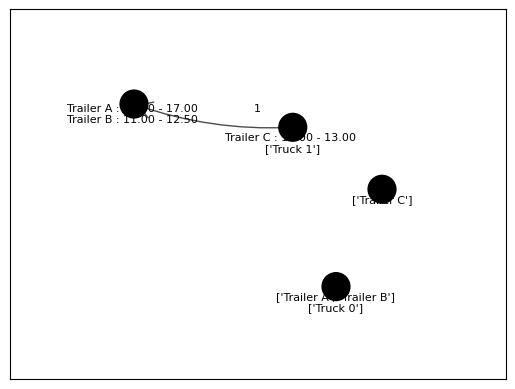

In [383]:
fig, ax = plt.subplots()
G = Network(num_nodes=4, num_trailers=3, num_trucks=2, plot_attributes=True)
# add edges that where visited
edges = [
    (0, 3, 'Truck 1', 'Trailer B', 1),
    (0, 3, 'Truck 0', None, 2),
    (3, 2, 'Truck 1', 'Trailer A', 3),
    (3, 2, 'Truck 0', 'Trailer C', 4),
]

print(G._nodes)
G.visit_edge(edges)
G.draw(ax=ax, with_labels=True)
